In [1]:
%cd coronavirus/

[Errno 2] No such file or directory: 'coronavirus/'
/workspace/coronavirus


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [14]:
# Coronavirus dashboard vaccination data
# https://coronavirus.data.gov.uk/details/healthcare#card-people_who_have_received_vaccinations_by_nation
json = requests.get('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newPeopleReceivingFirstDose%22:%22newPeopleReceivingFirstDose%22,%22cumPeopleReceivingFirstDose%22:%22cumPeopleReceivingFirstDose%22,%22newPeopleReceivingSecondDose%22:%22newPeopleReceivingSecondDose%22,%22cumPeopleReceivingSecondDose%22:%22cumPeopleReceivingSecondDose%22%7D&format=json').json()
vac = pd.DataFrame(json['data'])
vac['date'] = pd.to_datetime(vac['date'], format='%Y-%m-%d') # Format date column
vac.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981
1,nation,England,E92000001,2020-12-27,251940,804325,0,0
2,nation,England,E92000001,2020-12-20,552385,552385,0,0
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0


# Add a day n-1 value for zero values (i.e. assume no vaccines before the programme started)
dayZero = vac[['areaType', 'areaName','areaCode']].drop_duplicates()
dayZero['date'] = vac['date'].min() + pd.Timedelta(value=-1, unit='W') # Report is weekly
dayZero[['newPeopleReceivingFirstDose','cumPeopleReceivingFirstDose']] = 0 # No vaccines performed
vac = pd.concat([vac, dayZero], axis=0, ignore_index=True)
dayZero.head()

In [15]:
# Mid-year population estimates from ONS
# Source https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2019estimates#population-growth-in-england-wales-scotland-and-northern-ireland
pop = pd.read_csv('pop.csv')
pop.head()

,Country,Value,Measure
0,United Kingdom,66796807,Population mid-2019
1,England,56286961,Population mid-2019
2,Wales,3152879,Population mid-2019
3,Scotland,5463300,Population mid-2019
4,Northern Ireland,1893667,Population mid-2019


In [16]:
# Merge dataframes and drop duplicate column
df = vac.merge(pop, how='inner', left_on='areaName', right_on='Country')
df.drop(['Country'], axis=1, inplace=True)
df.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose,Value,Measure
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981,56286961,Population mid-2019
1,nation,England,E92000001,2020-12-27,251940,804325,0,0,56286961,Population mid-2019
2,nation,England,E92000001,2020-12-20,552385,552385,0,0,56286961,Population mid-2019
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271,1893667,Population mid-2019
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0,1893667,Population mid-2019


In [17]:
# Rename population value, drop measure
df = df.rename({'Value': 'popMid2019est'}, axis=1).drop('Measure', axis=1)
df.head()

,areaType,areaName,areaCode,date,newPeopleReceivingFirstDose,cumPeopleReceivingFirstDose,newPeopleReceivingSecondDose,cumPeopleReceivingSecondDose,popMid2019est
0,nation,England,E92000001,2021-01-03,288560,1092885,19981,19981,56286961
1,nation,England,E92000001,2020-12-27,251940,804325,0,0,56286961
2,nation,England,E92000001,2020-12-20,552385,552385,0,0,56286961
3,nation,Northern Ireland,N92000002,2021-01-03,9669,40685,1271,1271,1893667
4,nation,Northern Ireland,N92000002,2020-12-27,14948,31016,0,0,1893667


In [18]:
# Labelling actuals
df['Marker'] = 'Actual' 

In [19]:
df[['date','areaName','cumPeopleReceivingFirstDose']].pivot(index='date', columns='areaName', values='cumPeopleReceivingFirstDose')

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2020-12-13,NaN,3623.0,18734.0,8177.0
2020-12-20,552385.0,16068.0,58800.0,23461.0
2020-12-27,804325.0,31016.0,92324.0,35543.0
2021-01-03,1092885.0,40685.0,113459.0,49403.0


In [9]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def millions_formatter(x, pos):
    return f'{x / 1000000}'

formatter = FuncFormatter(millions_formatter)

In [10]:
shape = df[['date','areaName','cumPeopleReceivingFirstDose']].pivot(index='date', columns='areaName', values='cumPeopleReceivingFirstDose')
shape

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2020-12-13,NaN,3623.0,18734.0,8177.0
2020-12-20,552385.0,16068.0,58800.0,23461.0
2020-12-27,804325.0,31016.0,92324.0,35543.0
2021-01-03,1092885.0,40685.0,113459.0,49403.0


In [12]:
shape.count

<bound method DataFrame.count of areaName      England  Northern Ireland  Scotland    Wales
date                                                      
2020-12-13        NaN            3623.0   18734.0   8177.0
2020-12-20   552385.0           16068.0   58800.0  23461.0
2020-12-27   804325.0           31016.0   92324.0  35543.0
2021-01-03  1092885.0           40685.0  113459.0  49403.0>

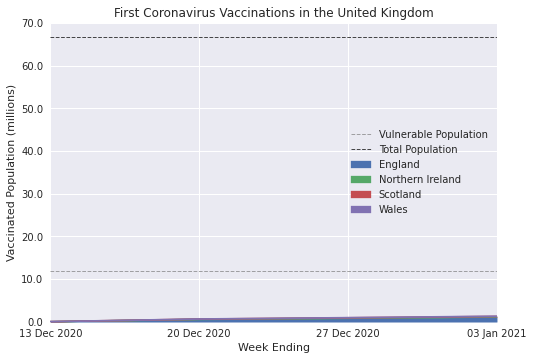

In [27]:
ax = shape.plot(xticks=shape.index, kind='area')
ylab = ax.set_ylabel('Vaccinated Population (millions)')
xlab = ax.set_xlabel('Week Ending')

ylim = ax.set_ylim(top=70000000)
yaxis = ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

vulnerable = 12000000
vuln = ax.axhline(vulnerable, c='grey', ls='dashed', lw=1, alpha=0.7, label='Vulnerable Population')

population = 66796807
pop = ax.axhline(population, c='black', ls='dashed', lw=1, alpha=0.7, label='Total Population')

ax.set_title('First Coronavirus Vaccinations in the United Kingdom')

xaxis = plt.xticks(shape.index, shape.index.strftime('%d %b %Y'))

plt.legend()

plt.show()